In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

%config InlineBackend.figure_format = 'retina'
sns.set()
rand = np.random.RandomState(95)

In [2]:
n = 100
p = 1000

μ = 0
σ = 2

x = rand.normal(μ, σ, size=(n, p))

Here, we create $p$ samples of $n$ measurements from a Gaussian population with mean $\mu$ and standard deviation $\sigma$.

Or in random variable terms for each sample,
$$
X_{1} \dots, X_{n} \overset{\text{i.i.d.}}{\sim} \mathrm{Normal}(\mu, \sigma^2).
$$

In [3]:
df = pd.DataFrame(x)
kwargs_melt = dict(var_name='sample', value_name='measurement')

sam = 10
base = alt.Chart(df.sample(sam, axis=1).melt(**kwargs_melt))


ruler = base.mark_rule(color='gray', strokeOpacity=0.9, size=2).encode(
    x='mu:Q'
).transform_calculate(mu=str(μ))

ticks = base.mark_tick(opacity=0.8).encode(
    x=alt.X('measurement:Q', title=''),
    y=alt.Y('sample:N'),
    color=alt.Color('sample:N')
)


# sample mean
circle = base.mark_circle(opacity=1.).encode(
    x='mean(measurement):Q',
    y=alt.Y('sample:N')
)

sm = alt.Chart(df.melt(**kwargs_melt).groupby('sample').mean())
kde = sm.mark_area(opacity=0.5).encode(
    x=alt.X('x̄:Q'),
    y=alt.Y('density:Q')
).transform_density(density='measurement', as_=['x̄', 'density']).properties(height=100)

((ticks + ruler + circle).interactive() & kde).resolve_scale(x='shared')

alt.VConcatChart(...)

Note that the samples are distributed 

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_{i} \\
\operatorname{Var}[\bar{X}_n] = \operatorname{Var}\left[ \frac{1}{n} \sum_{i=1}^n X_{i} \right] = \frac{\operatorname{Var}[X]}{n} \\
~\\
\bar{X}_n \overset{d}{\rightarrow} \mathrm{Normal}\left(\mu, \frac{\sigma^2}{n} \right) \\
$$

Mean of x̄:  -0.0102
StDev of x̄:  0.2013


Text(0.5, 0, '$\\bar{x}$')

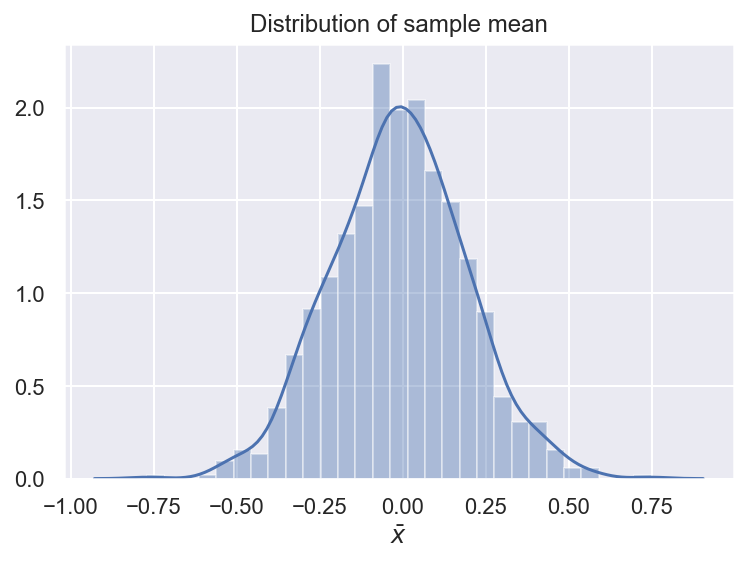

In [4]:
x̄ = np.mean(x, axis=0)
s = np.std(x, axis=0)

print(f'Mean of x̄:  {x̄.mean(): 0.4f}')
print(f'StDev of x̄: {x̄.std(): 0.4f}')

ax = sns.distplot(x̄)
ax.set_title('Distribution of sample mean')
ax.set_xlabel('$\\bar{x}$')

In [5]:
α = 0.95

threshold = stats.t.ppf(α + (1-α)/2, n-1)

In [6]:
df = pd.DataFrame(x).melt(var_name='sample')
#forbox = pd.DataFrame({'mean': df.groupby('sample').mean(), 'sd': df.groupby('sample').std()})

summary = df.groupby('sample').agg({'value': ['mean', 'std']})['value'].reset_index()
summary['sem'] = summary['std'] / np.sqrt(n)

# sem = df.groupby('sample').std()['value'] / np.sqrt(n)

# forbox['low'] = forbox['value'] - threshold * sem
# forbox['high'] = forbox['value'] + threshold * sem
# forbox['sig'] = (forbox['high'] < μ) | (forbox['low'] > μ)

In [7]:
from altair import datum

base = alt.Chart().transform_calculate(
    low=datum.mean - threshold * datum.sem,
    high=datum.mean + threshold * datum.sem,
    sig=alt.expr.if_((alt.datum.high < μ) | (alt.datum.low > μ), True, False)
)

# slider = alt.binding_range(min=0, max=1, step=10)
# select_year = alt.selection_single(name="year", fields=['year'],
#                                    bind=slider, init={'year': 2000})

points = base.mark_point(
    filled=True,
    color='sig:N'
).encode(
    x='sample:O',
    y='mean:Q',
)

errorbars = base.mark_errorbar().encode(
    x='sample:O',
    y='low:Q',
    y2='high:Q',
    color='sig:N',
    size='sig:N'
)

line = base.mark_rule(color='red').encode(
    y='line:Q'
).transform_calculate(line=str(μ))

text = base.mark_text(align='left', dx=5, dy=-100).encode(
        text=alt.Text('fuck2:N')
).transform_aggregate(fuck=f'mean(low)').transform_calculate(fuck2='datum.fuck + " units"')


alt.layer(points, errorbars, line, text, data=summary.sample(100)
         ).properties(width=800)

alt.LayerChart(...)